In [220]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [221]:
df=pd.read_csv('/content/retail_orders.csv')

Q1) Write a code to detect Anomalous Sales Weeks Using Rolling Mean.
Objective: Detect unusual weekly sales (spikes or drops) using 4-week rolling mean and std dev, and check if they’re linked to promotions. Concepts: Time Series, Pandas resample, Rolling mean/std, Anomaly detection, Promotion Attribution.

In [222]:
df.head()

,order_id,customer_id,order_date,product_id,category,quantity,unit_price,region,delivery_days,is_returned,promotion_applied
0,A0,C151,2022-02-03,P7,Mobile,0,738.56,East,1,0,0
1,A1,C192,2022-04-21,P10,Home,3,1793.57,North,4,0,0
2,A2,C114,2022-09-21,P19,Home,0,4057.74,North,2,1,1
3,A3,C171,2022-08-24,P19,Clothing,3,1307.11,West,8,0,1
4,A4,C160,2022-03-24,P12,Clothing,1,409.94,North,3,0,0


In [223]:
df.describe() #descriptive ideas

,quantity,unit_price,delivery_days,is_returned,promotion_applied
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,2.966000,2496.087920,5.117000,0.135000,0.190000
std,1.661808,1398.194372,2.536088,0.341895,0.392497
min,0.000000,101.180000,1.000000,0.000000,0.000000
25%,2.000000,1282.482500,3.000000,0.000000,0.000000
50%,3.000000,2463.225000,5.000000,0.000000,0.000000
75%,4.000000,3670.977500,7.000000,0.000000,0.000000
max,9.000000,4996.120000,9.000000,1.000000,1.000000


In [224]:
df['order_date']=pd.to_datetime(df['order_date'])

In [225]:
df['salesamount']=df['quantity']*df['unit_price']

In [226]:
df.head()

,order_id,customer_id,order_date,product_id,category,quantity,unit_price,region,delivery_days,is_returned,promotion_applied,salesamount
0,A0,C151,2022-02-03,P7,Mobile,0,738.56,East,1,0,0,0.00
1,A1,C192,2022-04-21,P10,Home,3,1793.57,North,4,0,0,5380.71
2,A2,C114,2022-09-21,P19,Home,0,4057.74,North,2,1,1,0.00
3,A3,C171,2022-08-24,P19,Clothing,3,1307.11,West,8,0,1,3921.33
4,A4,C160,2022-03-24,P12,Clothing,1,409.94,North,3,0,0,409.94


In [227]:
data=df['salesamount']

In [228]:
data.head()

,salesamount
0,0.00
1,5380.71
2,0.00
3,3921.33
4,409.94


In [229]:
data.index=df['order_date']

In [230]:
data.head()

,salesamount
order_date,
2022-02-03,0.00
2022-04-21,5380.71
2022-09-21,0.00
2022-08-24,3921.33
2022-03-24,409.94


In [231]:
weekly_sales = data.resample('W').agg({
    'sales': 'sum',
    'promotion_applied': 'sum'
})

In [232]:
weekly_sales['rolling_mean'] = weekly_sales['sales'].rolling(window=4).mean()
weekly_sales['rolling_std'] = weekly_sales['sales'].rolling(window=4).std()

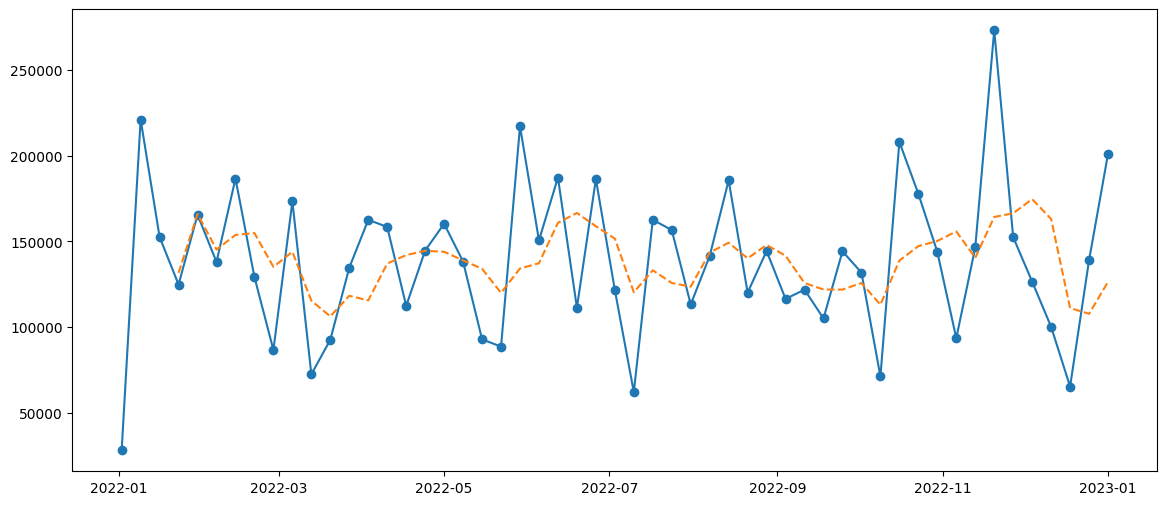

In [233]:
plt.figure(figsize=(14, 6))
plt.plot(weekly_sales.index, weekly_sales['sales'], label='Weekly Sales', marker='o')
plt.plot(weekly_sales.index, weekly_sales['rolling_mean'], label='4-Week Rolling Mean', linestyle='--')

In [234]:
weekly_sales['anomaly'] = (
    (weekly_sales['sales'] > weekly_sales['rolling_mean'] + 2 * weekly_sales['rolling_std']) |
    (weekly_sales['sales'] < weekly_sales['rolling_mean'] - 2 * weekly_sales['rolling_std'])
)

In [235]:
weekly_sales['promo_anomaly'] = weekly_sales['anomaly'] & (weekly_sales['promotion_applied'] > 0)

Q2) Write a code to detect Z-Test for Return Rate Differences by Region.
Objective: Use inferential statistics to test if return rates differ significantly between regions. Concepts: Two-proportion Z-test, p-value, statistical significance.

In [236]:
df.head()

,order_id,customer_id,order_date,product_id,category,quantity,unit_price,region,delivery_days,is_returned,promotion_applied,salesamount
0,A0,C151,2022-02-03,P7,Mobile,0,738.56,East,1,0,0,0.00
1,A1,C192,2022-04-21,P10,Home,3,1793.57,North,4,0,0,5380.71
2,A2,C114,2022-09-21,P19,Home,0,4057.74,North,2,1,1,0.00
3,A3,C171,2022-08-24,P19,Clothing,3,1307.11,West,8,0,1,3921.33
4,A4,C160,2022-03-24,P12,Clothing,1,409.94,North,3,0,0,409.94


In [237]:
from statsmodels.stats.proportion import proportions_ztest

In [238]:
region=df.groupby('region')['is_returned'].agg(['sum','count']).reset_index()

In [239]:
df.columns


Index(['order_id', 'customer_id', 'order_date', 'product_id', 'category',
       'quantity', 'unit_price', 'region', 'delivery_days', 'is_returned',
       'promotion_applied', 'salesamount'],
      dtype='object')

In [240]:
region.columns=['region','returns','total_orders']

In [241]:
results=[]

In [242]:
from itertools import combinations

In [243]:
for a, b in combinations(region['region'], 2):
    # Get data for both regions
    group1 = region[region['region'] == a]
    group2 = region[region['region'] == b]

    count = [int(group1['returns']), int(group2['returns'])]
    nobs = [int(group1['total_orders']), int(group2['total_orders'])]

    # Perform two-proportion Z-test
    stat, pval = proportions_ztest(count, nobs)

/tmp/ipython-input-243-2620336809.py:6: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  count = [int(group1['returns']), int(group2['returns'])]
/tmp/ipython-input-243-2620336809.py:7: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  nobs = [int(group1['total_orders']), int(group2['total_orders'])]


In [244]:
results.append({
        'Region 1': a,
        'Region 2': b,
        'Return Rate 1': count[0] / nobs[0],
        'Return Rate 2': count[1] / nobs[1],
        'Z-statistic': stat,
        'p-value': pval,
        'Significant at 0.05': pval < 0.05
    })


In [245]:

results_df = pd.DataFrame(results)
print("📊 Z-Test Results for Regional Return Rate Differences:")
print(results_df.sort_values(by='p-value'))

📊 Z-Test Results for Regional Return Rate Differences:
  Region 1 Region 2  Return Rate 1  Return Rate 2  Z-statistic   p-value  \
0    South     West       0.157025       0.142241     0.450852  0.652096   

   Significant at 0.05  
0                False  


Write a code to predict returns and cost evaluation.
Objective: Train a machine learning model to predict returns and calculate business cost of false predictions. Skills: LabelEncoder, RandomForestClassifier, f1_score, roc_auc_score, custom cost evaluation

In [246]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score,f1_score,confusion_matrix

In [247]:
from sklearn.model_selection import train_test_split

In [248]:
df.head()

,order_id,customer_id,order_date,product_id,category,quantity,unit_price,region,delivery_days,is_returned,promotion_applied,salesamount
0,A0,C151,2022-02-03,P7,Mobile,0,738.56,East,1,0,0,0.00
1,A1,C192,2022-04-21,P10,Home,3,1793.57,North,4,0,0,5380.71
2,A2,C114,2022-09-21,P19,Home,0,4057.74,North,2,1,1,0.00
3,A3,C171,2022-08-24,P19,Clothing,3,1307.11,West,8,0,1,3921.33
4,A4,C160,2022-03-24,P12,Clothing,1,409.94,North,3,0,0,409.94


In [249]:
le=LabelEncoder()

In [250]:
columns=['category','region']

In [251]:
df=df.drop('customer_id',axis=1)

In [252]:
df=df.drop('product_id',axis=1)

In [253]:
df=df.drop('order_id',axis=1)

In [254]:
df=df.drop('order_date',axis=1)

In [255]:
for i in columns:
  df[i]=le.fit_transform(df[i])

In [256]:
X=df.drop(['is_returned'],axis=1)
y=df['is_returned']

In [257]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=0)

In [258]:
rfc=RandomForestClassifier()

In [259]:
rfc.fit(X_train,y_train)

RandomForestClassifier()

In [260]:
X_test

,category,quantity,unit_price,region,delivery_days,promotion_applied,salesamount
993,3,5,3911.60,2,9,0,19558.00
859,1,5,3238.37,0,9,0,16191.85
298,3,6,1874.69,1,3,0,11248.14
553,2,3,744.67,1,2,0,2234.01
672,3,3,2041.76,3,6,0,6125.28
...,...,...,...,...,...,...,...
679,1,6,3562.55,0,1,0,21375.30
722,3,3,221.02,3,5,0,663.06
215,1,3,4721.66,1,6,0,14164.98
653,0,2,2463.55,0,6,0,4927.10


In [261]:
y_pred=rfc.predict(X_test)

In [262]:
y_pred

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0])

In [263]:
roc_auc_score(y_pred,y_test)

np.float64(0.9472361809045226)

In [264]:
f1_score(y_test,y_pred)

0.08695652173913043

In [270]:
confusion_matrix(y_test, y_pred)

array([[178,   0],
       [ 21,   1]])

In [272]:
cost_false_positive = 5   # predicted return, but wasn't (extra handling)
cost_false_negative = 50  # failed to predict actual return (loss, shipping, restocking)

# Confusion matrix: [TN, FP], [FN, TP]


# Calculate total cost
total_cost = 0 * cost_false_positive + 21 * cost_false_negative

print(f"💸 Total Business Cost of Misclassification: ₹{total_cost}")
print(f" False Positives: {0} (₹{0 * cost_false_positive})")
print(f" False Negatives: {21} (₹{21 * cost_false_negative})")

💸 Total Business Cost of Misclassification: ₹1050
 False Positives: 0 (₹0)
 False Negatives: 21 (₹1050)


Q4) Write a code to Segment Customers by Order Volatility
Objective: Segment customers by how much their order value varies, using NumPy quantiles, and compare return rates across segments. Concepts: Feature engineering, customer segmentation, NumPy quantiles, volatility.

In [274]:
df=pd.read_csv('/content/retail_orders.csv')

In [275]:
df['order_value']=df['quantity']*df['unit_price']

In [276]:
df.head()

,order_id,customer_id,order_date,product_id,category,quantity,unit_price,region,delivery_days,is_returned,promotion_applied,order_value
0,A0,C151,2022-02-03,P7,Mobile,0,738.56,East,1,0,0,0.00
1,A1,C192,2022-04-21,P10,Home,3,1793.57,North,4,0,0,5380.71
2,A2,C114,2022-09-21,P19,Home,0,4057.74,North,2,1,1,0.00
3,A3,C171,2022-08-24,P19,Clothing,3,1307.11,West,8,0,1,3921.33
4,A4,C160,2022-03-24,P12,Clothing,1,409.94,North,3,0,0,409.94


In [277]:
customer_volatility = df.groupby('customer_id')['order_value'].std().reset_index()

In [278]:
customer_volatility.columns = ['customer_id', 'order_volatility']

In [279]:
customer_volatility['order_volatility'].fillna(0, inplace=True)

/tmp/ipython-input-279-14254585.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  customer_volatility['order_volatility'].fillna(0, inplace=True)


In [280]:
q_low, q_high = np.quantile(customer_volatility['order_volatility'], [0.33, 0.66])

# Assign segments based on quantiles
def segment_volatility(vol):
    if vol <= q_low:
        return 'Low Volatility'
    elif vol <= q_high:
        return 'Medium Volatility'
    else:
        return 'High Volatility'

customer_volatility['volatility_segment'] = customer_volatility['order_volatility'].apply(segment_volatility)


In [281]:
df = df.merge(customer_volatility[['customer_id', 'volatility_segment']], on='customer_id', how='left')